# ==========================================
# House Price Prediction using Machine Learning
# ==========================================
# This notebook trains an XGBoost regression model
# on the Boston Housing dataset and provides
# an inference function for price prediction.


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor


In [122]:
# Load the Boston housing dataset
boston_dataset = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/MachineLearningCourseWithPython/data/boston.csv'
)

# Display first few rows
boston_dataset.head()


,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [123]:
# Dataset shape
boston_dataset.shape

# Dataset info
boston_dataset.info()

# Remove unnecessary index column
boston_dataset.drop(columns=['Unnamed: 0'], inplace=True)

# Check for missing values
boston_dataset.isnull().sum()

# Statistical summary
boston_dataset.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    float64
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    float64
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  B           506 non-null    float64
 13  LSTAT       506 non-null    float64
 14  PRICE       506 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 59.4 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


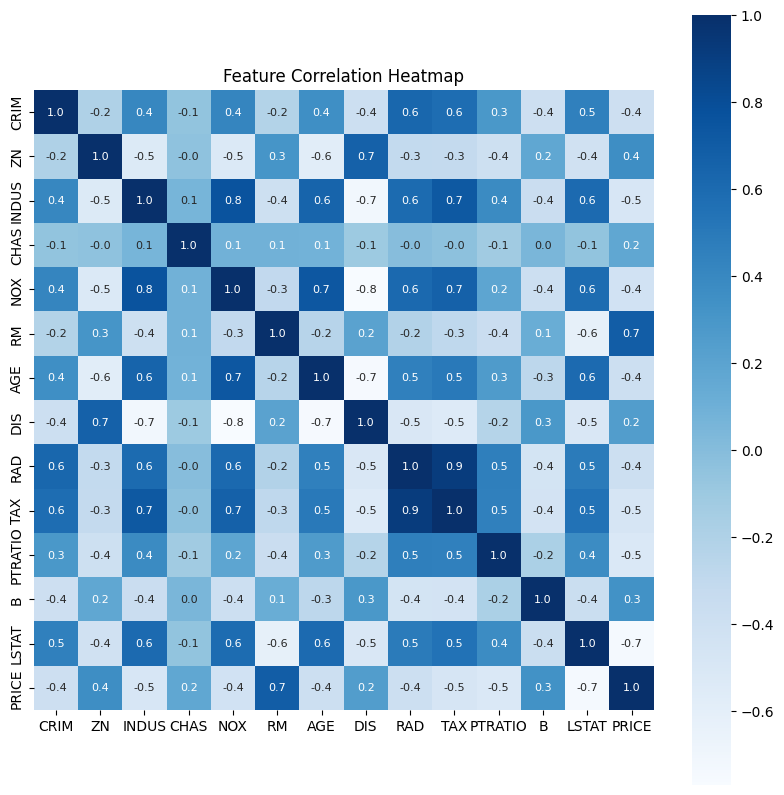

In [124]:
# Correlation matrix
correlation = boston_dataset.corr()

# Heatmap visualization
plt.figure(figsize=(10, 10))
sns.heatmap(
    correlation,
    cbar=True,
    square=True,
    fmt='.1f',
    annot=True,
    annot_kws={'size': 8},
    cmap='Blues'
)
plt.title("Feature Correlation Heatmap")
plt.show()


In [125]:
# Features (X) and Target (Y)
X = boston_dataset.drop(columns=['PRICE'])
Y = boston_dataset['PRICE']

X.head(), Y.head()


(      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
 0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
 1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
 2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
 3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
 4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
 
    PTRATIO       B  LSTAT  
 0     15.3  396.90   4.98  
 1     17.8  396.90   9.14  
 2     17.8  392.83   4.03  
 3     18.7  394.63   2.94  
 4     18.7  396.90   5.33  ,
 0    24.0
 1    21.6
 2    34.7
 3    33.4
 4    36.2
 Name: PRICE, dtype: float64)

In [126]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=2
)

print("Training set:", X_train.shape)
print("Testing set :", X_test.shape)


Training set: (404, 13)
Testing set : (102, 13)


In [127]:
# Initialize XGBoost Regressor
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2
)

# Train the model
model.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [128]:
# Predictions on training data
train_predictions = model.predict(X_train)

# Evaluation metrics
print("Training R² Score:", metrics.r2_score(Y_train, train_predictions))
print("Training MAE:", metrics.mean_absolute_error(Y_train, train_predictions))
print("Training MSE:", metrics.mean_squared_error(Y_train, train_predictions))
print("Training RMSE:", np.sqrt(metrics.mean_squared_error(Y_train, train_predictions)))


Training R² Score: 0.9949981314926178
Training MAE: 0.4909148383848739
Training MSE: 0.4230075204508644
Training RMSE: 0.650390283176851


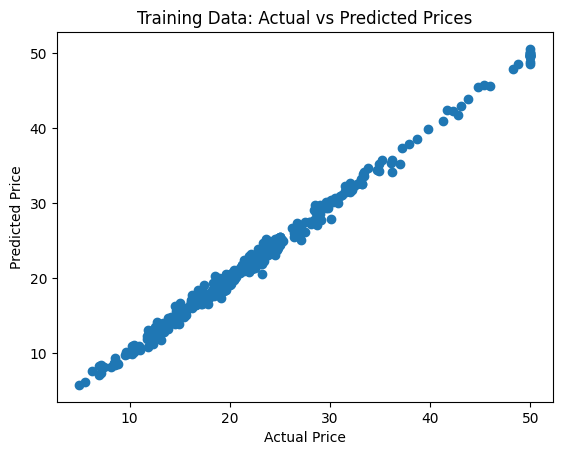

In [129]:
plt.scatter(Y_train, train_predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Training Data: Actual vs Predicted Prices")
plt.show()


In [130]:
# Predictions on test data
test_predictions = model.predict(X_test)

# Evaluation metrics
print("Test R² Score:", metrics.r2_score(Y_test, test_predictions))
print("Test MAE:", metrics.mean_absolute_error(Y_test, test_predictions))
print("Test MSE:", metrics.mean_squared_error(Y_test, test_predictions))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(Y_test, test_predictions)))


Test R² Score: 0.9286884498160591
Test MAE: 1.8085455885120465
Test MSE: 5.965901600842253
Test RMSE: 2.4425195190299407


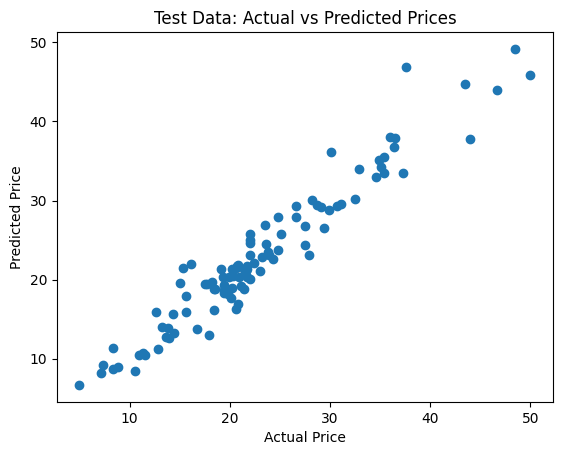

In [131]:
plt.scatter(Y_test, test_predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Test Data: Actual vs Predicted Prices")
plt.show()


In [132]:
# Save trained model
# model.save_model("xgb_house_price_model.json")


In [133]:
def predict_price(input_tuple, model):
    """
    Predicts house price for a single input row.

    Parameters:
    input_tuple : tuple
        A tuple containing feature values in the same order as training data.
    model : trained XGBRegressor model

    Returns:
    float : predicted house price
    """
    input_array = np.array(input_tuple).reshape(1, -1)
    prediction = model.predict(input_array)
    return prediction[0]


In [134]:
# Example input (13 features, no PRICE)
input_tuple = (
    0.02729,  # CRIM
    0.0,      # ZN
    7.07,     # INDUS
    0.0,      # CHAS
    0.469,    # NOX
    7.185,    # RM
    61.1,     # AGE
    4.9671,   # DIS
    2.0,      # RAD
    242.0,    # TAX
    17.8,     # PTRATIO
    392.83,   # B
    4.03      # LSTAT
)

predicted_price = predict_price(input_tuple, model)

print(f"Predicted House Price: ${predicted_price:.2f} thousand")


Predicted House Price: $34.42 thousand
